In [153]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from loader import *
from scipy import signal
from sklearn.cluster import KMeans
# import spikeinterface as si  # import core only
# import spikeinterface.extractors as se
# import spikeinterface.preprocessing as spre
# import spikeinterface.sorters as ss
# import spikeinterface.postprocessing as spost
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.comparison as sc
# import spikeinterface.exporters as sexp
# import spikeinterface.curation as scur
# import spikeinterface.widgets as sw

'''
from loader:

data, info = loadescope(filename)
plotescope(data, info) # plots whole thing
plot_region(data, info, t_on, t_off) # plots region between [t_on, t_off] seconds
plot_spike(data, info, t_spike, window_size=500, thresh=25, savedir=None) 
    # t_spike (seconds), window_size (1e-5 seconds), thresh (SNR, mV)
plot_all_spikes(data, info, t_start, t_end, savedir)
'''
plt.ion()
# global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
# si.full.set_global_job_kwargs(**global_job_kwargs)

### From Lab 4

In previous weeks, I implemented basic spike sorting, which simply logs windows where spikes surpass some given threshold. 

key=[rundate] value=['20231127-140628']
key=[rate_hz] value=[10000]
key=[channels] value=[{ 'ai5' 'ai7' }]
key=[nchannels] value=[2]
key=[scale] value=[{ '1 V']
key=[scans_per_sweep] value=[10000]
key=[sweepperiod_s] value=[1]
{'rundate': '20231127-140628', 'rate_hz': 10000, 'channels': ['ai5', 'ai7'], 'nchannels': 2, 'scale': ['1 V', '1 V'], 'scans_per_sweep': 10000, 'sweepperiod_s': 1}


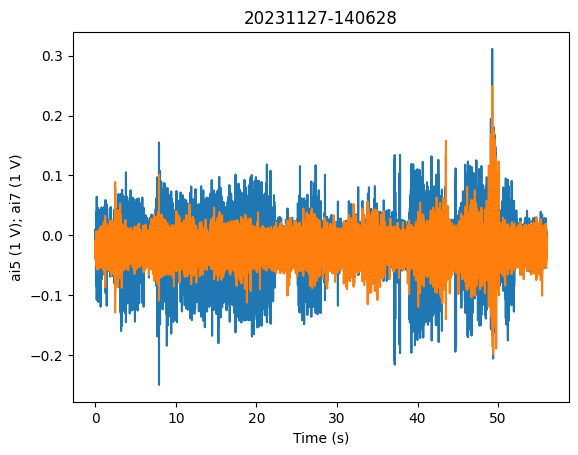

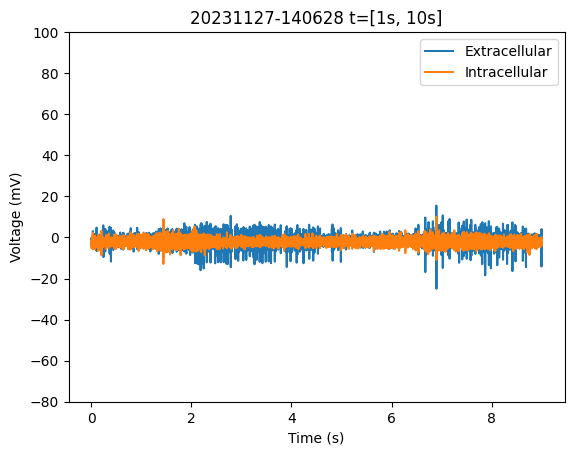

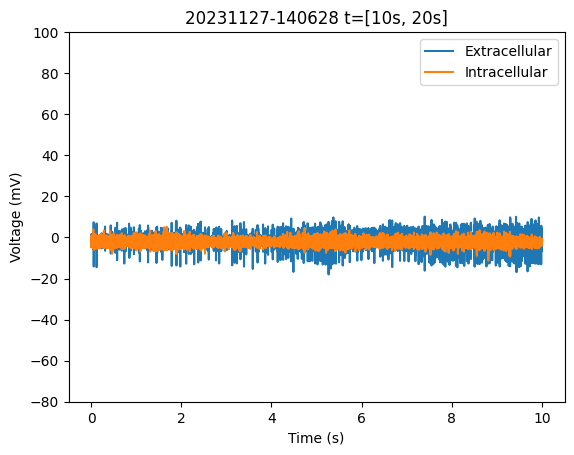

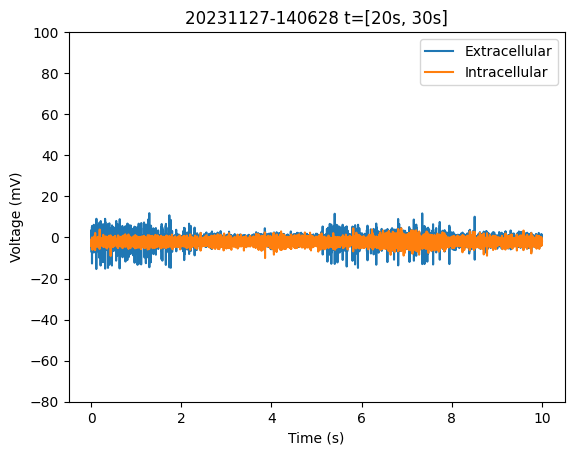

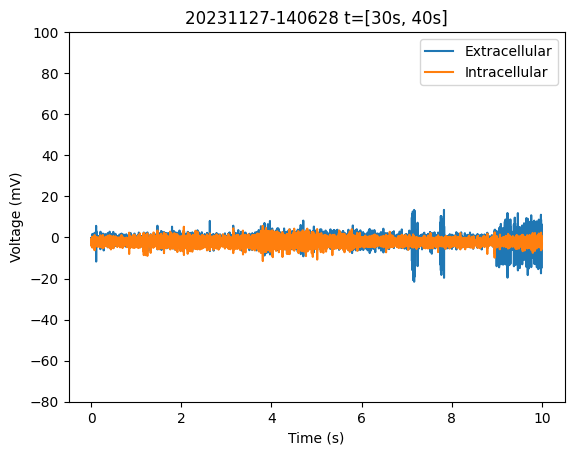

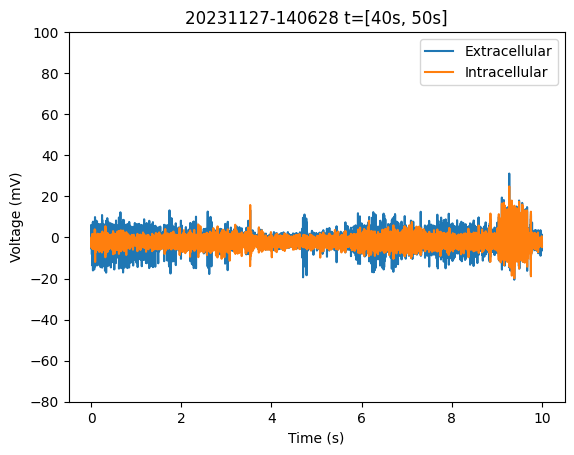

In [154]:
data, info = loadescope('../final_data/day3/20231127-140628.dat')
plotescope(data, info)
plot_region(data, info, 1, 10)
plot_region(data, info, 10, 20)
plot_region(data, info, 20, 30)
plot_region(data, info, 30, 40)
plot_region(data, info, 40, 50)

# Simple clustering method 

In [155]:
def cluster(filename, ch_no, n_clusters, boundary=10): 
    def localize(t, ch):
        t_max = np.argmax(ch[t:t+500])
        # Shift window at edges
        if t_max == 0: return localize(t - 200, ch)
        if t_max == 499: return localize(t + 200, ch)
        return (t + t_max, ch[t + t_max - 25:t + t_max + 50])

    data, info = loadescope(filename)
    ch_1 = data.reshape(2, -1)[ch_no] * 100 # convert to mV
    # Limit noise between [-boundary, boundary]
    bound = lambda x, b, fn: fn(np.array([x, np.ones(len(x)) * b]), axis=0)
    ch_1 = bound(bound(data.reshape(2, -1)[1] * 100, boundary, np.min), -boundary, np.max)
    n_secs = len(ch_1) // 10000
    # Bandpass filter between 300 and 3000 Hz
    bp_filter = signal.butter(10, [300, 3000], 'bandpass', fs=10000, output='sos')
    filtered = signal.sosfilt(bp_filter, ch_1)
    # Spike detection using threshold
    threshold = np.median(abs(filtered)) * 5 / 0.6745 # Quian Quiroga et al. (2004)
    spike_windows = [t for t in range(0, len(ch_1), 500) if sum(ch_1[t:t+500] > threshold)]
    # Align using maximum (reasonable since we are using sufficiently high sampling rate)
    aligned_spikes = [localize(t, ch_1) for t in spike_windows] 
    # Cluster spikes
    kmeans = KMeans(n_clusters, random_state=0).fit([x[1] for x in aligned_spikes])
    spike_clusters = kmeans.labels_

    # Plot bandpass filter
#     plt.plot(ch_1)
#     plt.plot(filtered)
#     plt.xlabel('Time (s)'); plt.ylabel('Voltage (mV)'); plt.xlim(0, n_secs * 10000)
#     plt.xticks([t * 10000 for t in range(n_secs + 1)], [t for t in range(n_secs + 1)])
#     plt.legend(['Raw signal', 'Signal after bandpass filter'], loc=(1.05, 0.8))
#     plt.title('Effect of bandpass filter (300-3000 Hz, 10th order Butterworth) on neural recording')
#     plt.show()

    # Plot spike detection
    plt.plot(filtered)
    plt.scatter(spike_windows, [threshold * 5] * len(spike_windows))
    plt.plot([0, n_secs * 10000], [threshold, threshold], c='orange')
    plt.plot([0, n_secs * 10000], [-threshold, -threshold], c='orange')
    plt.xlabel('Time (s)'); plt.ylabel('Voltage (mV)'); plt.xlim(0, n_secs * 10000)
    plt.xticks([t * 10000 for t in range(n_secs + 1, 10)], [t for t in range(n_secs + 1, 10)])
    plt.legend(['Filtered signal', 'Detected spikes', 'Spike detecting threshold'], loc=(1.05, 0.8))
    plt.title('Spike detection and localization using threshold')
    plt.show()

    # Plot aligned, but unclustered spikes
    for i, (t, spike) in enumerate(aligned_spikes):
        plt.plot(spike, c='b')
    plt.title('Aligned spikes')
    plt.xlabel('Time (1e-5 secs)')
    plt.ylabel('Voltage (mV)')
    plt.show()

    # Plot spike cluster centers
    for k in range(n_clusters): plt.plot(kmeans.cluster_centers_[k])
    plt.title('Means of neuronal spike clusters')
    plt.xlabel('Time (1e-5 secs)')
    plt.ylabel('Voltage (mV)')
    plt.show()

    # Plot aligned and clustered spikes
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for i, (t, spike) in enumerate(aligned_spikes):
        plt.plot(spike, c=colors[spike_clusters[i]], label=spike_clusters[i])

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(
        by_label.values(), 
        [f'Cluster {k} ({sum(spike_clusters == int(k))} spikes)' for k in by_label.keys()])
    plt.title('Neuronal spike clusters')
    plt.xlabel('Time (1e-5 secs)')
    plt.ylabel('Voltage (mV)')
    plt.show()
    
    return aligned_spikes, spike_clusters

In [156]:
def cluster_multiple(filenames, n_clusters, ch_no=1, boundary=11, threshold=10): 
    def localize(t, ch):
        t_max = np.argmax(ch[t:t+500])
        # Shift window at edges
        if t_max == 0: return localize(t - 200, ch)
        if t_max == 499: return localize(t + 200, ch)
        return (t + t_max, ch[t + t_max - 25:t + t_max + 50])

    aligned_spikes = {}
    for loc, filename in filenames.items():
        data, info = loadescope(filename)
        ch_1 = data.reshape(2, -1)[ch_no] * 100 # convert to mV
        # Limit noise between [-boundary, boundary]
        bound = lambda x, b, fn: fn(np.array([x, np.ones(len(x)) * b]), axis=0)
        ch_1 = bound(bound(data.reshape(2, -1)[1] * 100, boundary, np.min), -boundary, np.max)
        n_secs = len(ch_1) // 10000
        # Bandpass filter between 300 and 3000 Hz
        bp_filter = signal.butter(10, [300, 3000], 'bandpass', fs=10000, output='sos')
        filtered = signal.sosfilt(bp_filter, ch_1)
        # Spike detection using threshold
        #threshold = np.median(abs(filtered)) * 4 / 0.6745 # Quian Quiroga et al. (2004)
        spike_windows = [t for t in range(0, len(ch_1), 500) if sum(ch_1[t:t+500] > threshold)]
        # Align using maximum (reasonable since we are using sufficiently high sampling rate)
        aligned_spikes[loc] = [localize(t, ch_1) for t in spike_windows]

    # Cluster spikes
    all_spikes = []
    for s in aligned_spikes.values(): all_spikes += [x[1] for x in s]
    kmeans = KMeans(n_clusters, random_state=0).fit(all_spikes)
    all_clusters = kmeans.labels_
    spike_clusters = {}
    for loc, spikes in aligned_spikes.items():
        spike_clusters[loc] = kmeans.predict([x[1] for x in spikes])

    # Plot bandpass filter
#     plt.plot(ch_1)
#     plt.plot(filtered)
#     plt.xlabel('Time (s)'); plt.ylabel('Voltage (mV)'); plt.xlim(0, n_secs * 10000)
#     plt.xticks([t * 10000 for t in range(n_secs + 1)], [t for t in range(n_secs + 1)])
#     plt.legend(['Raw signal', 'Signal after bandpass filter'], loc=(1.05, 0.8))
#     plt.title('Effect of bandpass filter (300-3000 Hz, 10th order Butterworth) on neural recording')
#     plt.show()

    # Plot spike detection
    plt.plot(filtered)
    plt.scatter(spike_windows, [threshold * 5] * len(spike_windows))
    plt.plot([0, n_secs * 10000], [threshold, threshold], c='orange')
    plt.plot([0, n_secs * 10000], [-threshold, -threshold], c='orange')
    plt.xlabel('Time (s)'); plt.ylabel('Voltage (mV)'); plt.xlim(0, n_secs * 10000)
    plt.xticks([t * 10000 for t in range(n_secs + 1, 10)], [t for t in range(n_secs + 1, 10)])
    plt.legend(['Filtered signal', 'Detected spikes', 'Spike detecting threshold'], loc=(1.05, 0.8))
    plt.title('Spike detection and localization using threshold')
    plt.show()

    # Plot aligned, but unclustered spikes
    for i, spike in enumerate(all_spikes):
        plt.plot(spike, c='b')
    plt.title('Aligned spikes')
    plt.xlabel('Time (1e-5 secs)')
    plt.ylabel('Voltage (mV)')
    plt.show()

    # Plot spike cluster centers
    for k in range(n_clusters): plt.plot(kmeans.cluster_centers_[k])
    plt.title('Means of neuronal spike clusters')
    plt.xlabel('Time (1e-5 secs)')
    plt.ylabel('Voltage (mV)')
    plt.show()

    # Plot aligned and clustered spikes
    fig, axs = plt.subplots(n_clusters, figsize=(4, 8))
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for i, spike in enumerate(all_spikes):
        k = all_clusters[i]
        axs[k].plot(spike, c=colors[k]) # , label=k)
        axs[k].set_title(f'Cluster {k} ({sum(all_clusters == k)} spikes)')
        if k in [0, 1]: axs[k].set_xticks([],[])

#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(
#         by_label.values(), 
#         [f'Cluster {k} ({sum(all_clusters == int(k))} spikes)' for k in by_label.keys()])
#     plt.title('Neuronal spike clusters')
    plt.xlabel('Time (1e-5 secs)')
    plt.ylabel('Voltage (mV)')
    plt.show()
    
    return aligned_spikes, spike_clusters

In [157]:
aligned_spikes, spike_clusters = cluster('../final_data/day3/20231127-134506.dat', 1, 3, boundary=60, threshold=13)
aligned_spikes, spike_clusters = cluster('../final_data/day3/20231127-140628.dat', 1, 3, boundary=60, threshold=13)

TypeError: cluster() got an unexpected keyword argument 'threshold'

### Femur position response

In [ ]:
filenames = {
    #'5847': '../final_data/day3/20231127-135847.dat',
    '0628': '../final_data/day3/20231127-140628.dat'
}

key=[rundate] value=['20231127-140628']
key=[rate_hz] value=[10000]
key=[channels] value=[{ 'ai5' 'ai7' }]
key=[nchannels] value=[2]
key=[scale] value=[{ '1 V']
key=[scans_per_sweep] value=[10000]
key=[sweepperiod_s] value=[1]
{'rundate': '20231127-140628', 'rate_hz': 10000, 'channels': ['ai5', 'ai7'], 'nchannels': 2, 'scale': ['1 V', '1 V'], 'scans_per_sweep': 10000, 'sweepperiod_s': 1}


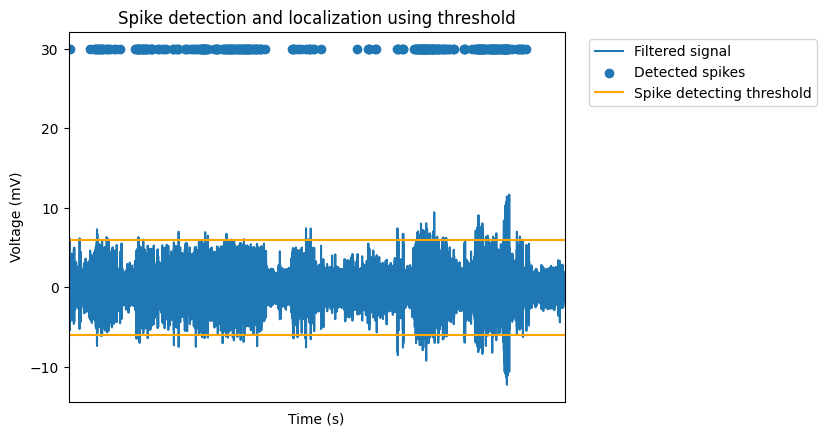

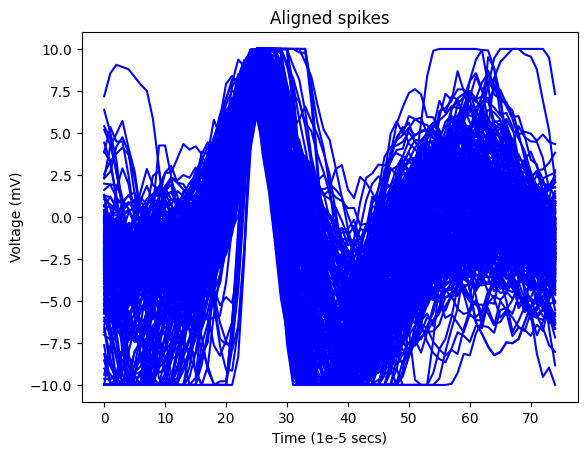

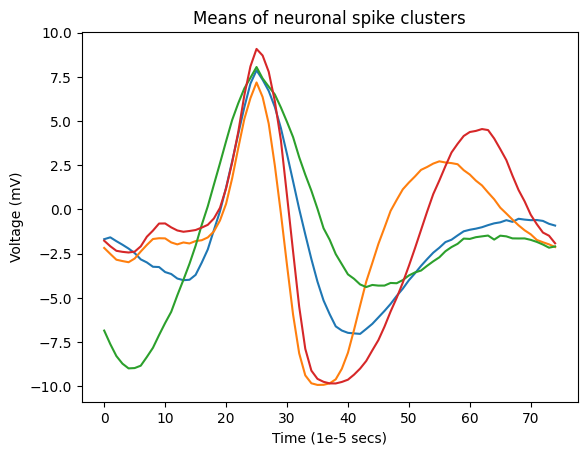

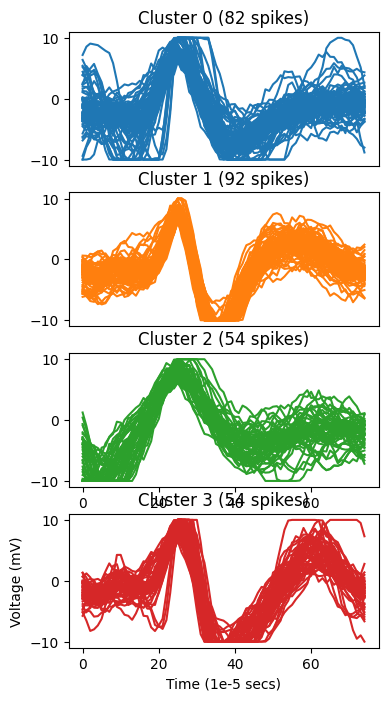

In [ ]:
aligned_spikes, spike_clusters = cluster_multiple(filenames, n_clusters=4, ch_no=1, boundary=10, threshold=6)

In [ ]:
spike_clusters['0628']

array([0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1, 3, 0, 1, 0, 0, 1, 0, 1, 1, 0, 3,
       0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 3, 1, 1, 0, 1, 0, 3,
       1, 1, 0, 1, 3, 1, 1, 1, 0, 3, 1, 1, 0, 1, 1, 3, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 3, 1, 0, 1, 1, 2, 0,
       1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 2, 3, 1, 1, 2,
       0, 2, 2, 2, 2, 3, 3, 1, 2, 2, 2, 0, 2, 0, 2, 3, 2, 2, 3, 1, 3, 3,
       1, 3, 1, 2, 1, 1, 0, 0, 3, 1, 1, 0, 0, 0, 2, 0, 0, 0, 3, 1, 1, 2,
       3, 3, 1, 1, 3, 1, 0, 1, 3, 1, 0, 1, 3, 1, 1, 3, 3, 2, 3, 3, 1, 3,
       1, 3, 2, 1, 1, 1, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       3, 3, 1, 0, 1, 3, 1, 2, 0, 2, 2, 2, 0, 2, 3, 1, 3, 2, 0, 3, 0, 0,
       2, 3, 3, 3, 3, 2, 1, 0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2,
       2, 2, 0, 1, 0, 0, 2, 0, 0, 3, 3, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       3, 3, 0, 2, 0, 0, 0, 3, 0, 2, 0, 0, 3, 1, 1, 2, 2, 3])

In [ ]:
trial_times = {
   #'5847': [[17,20],[21,24],[30,32],[35,45],[46,48],[50,53],[54,58],[60,62],[66,68],[68,70],[72,74],[75,77]],
    '0628': [[2,4],[6,10],[15,20],[25,28],[35,40],[40,43],[45,49]]
    
}

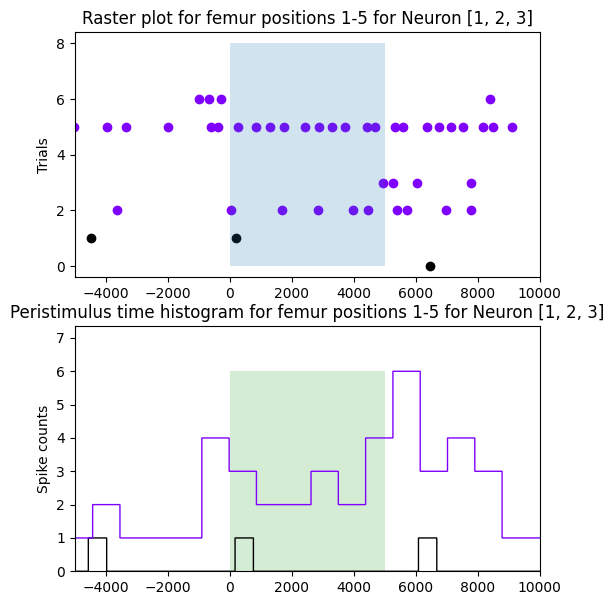

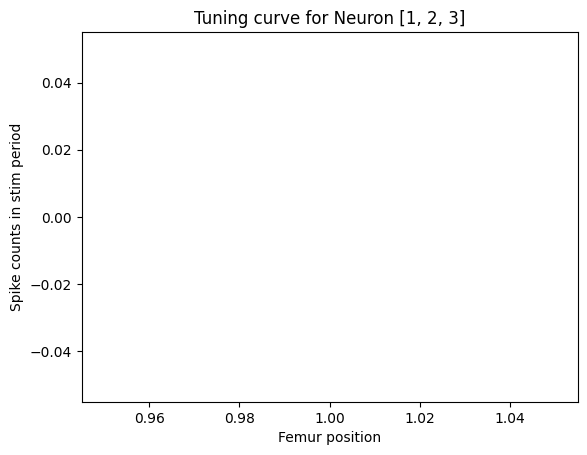

In [158]:
for cluster1 in [[1,2,3]]:
    colors = [(i * 0.1, i * 0, i * 0.2) for i in range(10)] # list(mcolors.TABLEAU_COLORS.keys())
    fig, ax = plt.subplots(2, figsize=(6, 7))

    density = []
    for i in range(1, 2):
        loc = list(trial_times.keys())[i - 1]
        times_low, times_med = [], []
        for j, t_s in enumerate(trial_times[loc]):
            times = [t - (t_s[0] * 10000) + 2000 for i, [t, s] 
                     in enumerate(aligned_spikes[loc]) 
                      if spike_clusters[loc][i] in cluster1] 
            ax[0].scatter(times, [j] * len(times), color=colors[5 if j > 1 else 0])
            if j > 1: times_med.extend(times)
            else: times_low.extend(times)
#         times = [t - (t_s[0] * 10000) + 2500 for i, [t, s] 
#                      in enumerate(aligned_spikes[loc]) 
#                       if spike_clusters[loc][i] in cluster
#                 for t_s in trial_times[loc]]
        ax[1].hist(times_low, color=colors[0], bins=int(trial_times[loc][-1][0] * 20), histtype='step')
        ax[1].hist(times_med, color=colors[5], bins=int(trial_times[loc][-1][0] * 20), histtype='step')

        times = np.array(times)
        g0 = times[times > 0]
        l5000 = g0[g0 < 5000]
        density.append(len(l5000))
    # for t_s in trial_times[loc]:
    #     plt.eventplot([
    #         [t - (t_s * 10000)
    #           for i, [t, s] 
    #           in enumerate(aligned_spikes[loc]) 
    #           if spike_clusters[loc][i] == 0] 
    #             loc = f'femur{i+1}', colors=colors[:5])
    ax[0].set_xlim([-5000, 10000]); ax[1].set_xlim([-5000, 10000])
    x = [0, 5000]
    y1 = [0, 0]
    ax[0].fill_between(x, y1, 8, alpha=0.2); ax[1].fill_between(x, y1, 6, alpha=0.2)
    ax[0].set_title(f'Raster plot for femur positions 1-5 for Neuron {cluster1}')
    ax[0].set_ylabel('Trials'); ax[1].set_ylabel('Spike counts')
    ax[1].set_title(f'Peristimulus time histogram for femur positions 1-5 for Neuron {cluster1}')
    plt.show()

    plt.plot([x for x in range(1, 2)], density)
    plt.xlabel('Femur position')
    plt.ylabel('Spike counts in stim period')
    plt.title(f'Tuning curve for Neuron {cluster1}')
    plt.show()

### Femur response adapation

key=[rundate] value=['20231127-140628']
key=[rate_hz] value=[10000]
key=[channels] value=[{ 'ai5' 'ai7' }]
key=[nchannels] value=[2]
key=[scale] value=[{ '1 V']
key=[scans_per_sweep] value=[10000]
key=[sweepperiod_s] value=[1]
{'rundate': '20231127-140628', 'rate_hz': 10000, 'channels': ['ai5', 'ai7'], 'nchannels': 2, 'scale': ['1 V', '1 V'], 'scans_per_sweep': 10000, 'sweepperiod_s': 1}


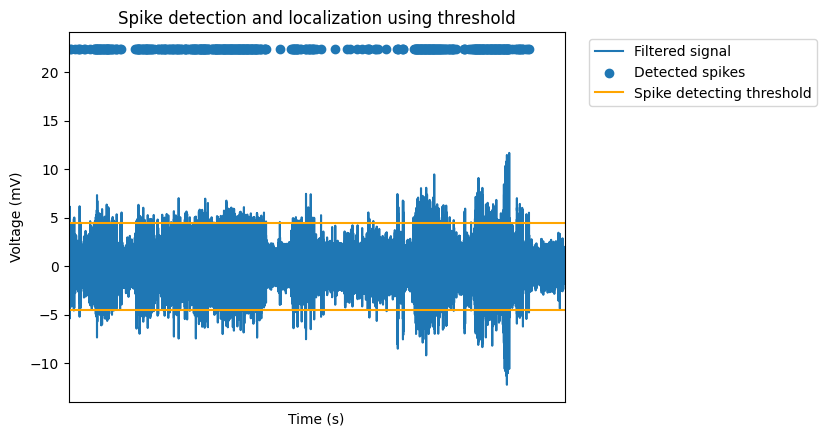

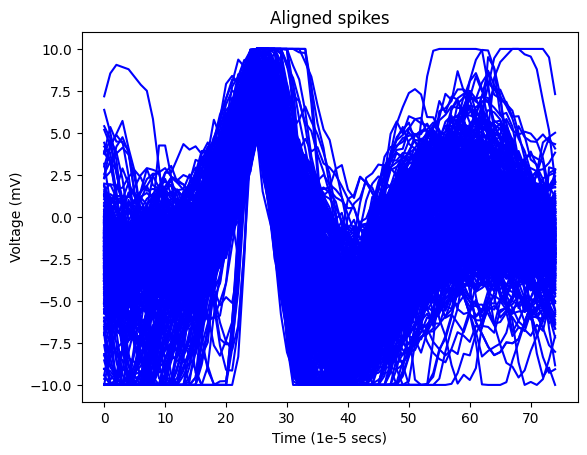

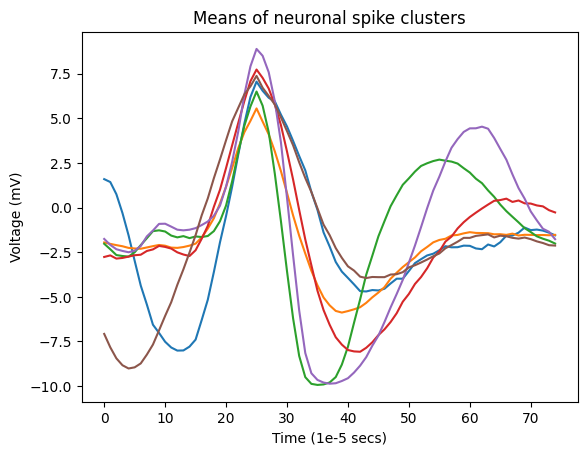

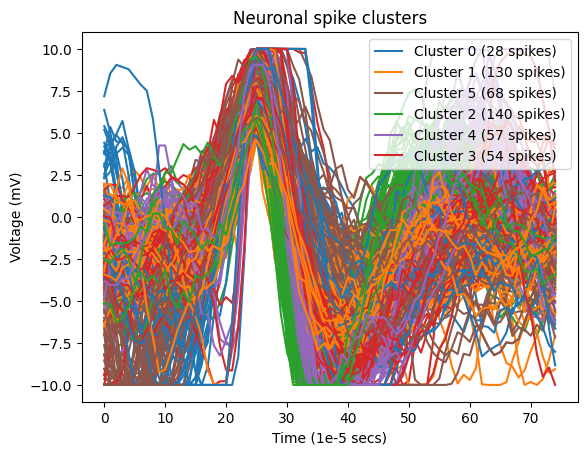

In [163]:
adaptation_3 = '../final_data/day3/20231127-140628.dat'
aligned_spikes, spike_clusters = cluster(adaptation_3, 1, 6)

key=[rundate] value=['20231127-140628']
key=[rate_hz] value=[10000]
key=[channels] value=[{ 'ai5' 'ai7' }]
key=[nchannels] value=[2]
key=[scale] value=[{ '1 V']
key=[scans_per_sweep] value=[10000]
key=[sweepperiod_s] value=[1]
{'rundate': '20231127-140628', 'rate_hz': 10000, 'channels': ['ai5', 'ai7'], 'nchannels': 2, 'scale': ['1 V', '1 V'], 'scans_per_sweep': 10000, 'sweepperiod_s': 1}


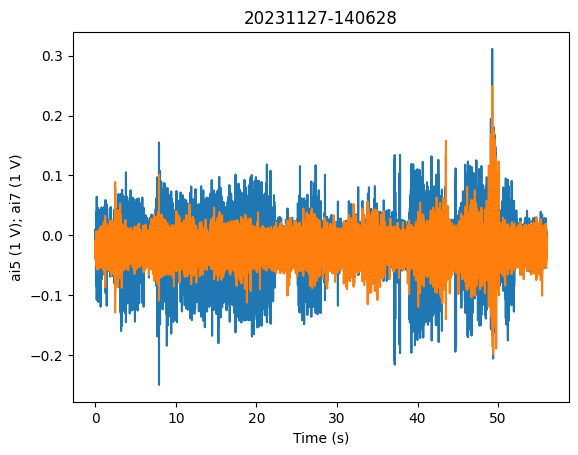

In [164]:
data, info = loadescope(adaptation_3)
plotescope(data, info)

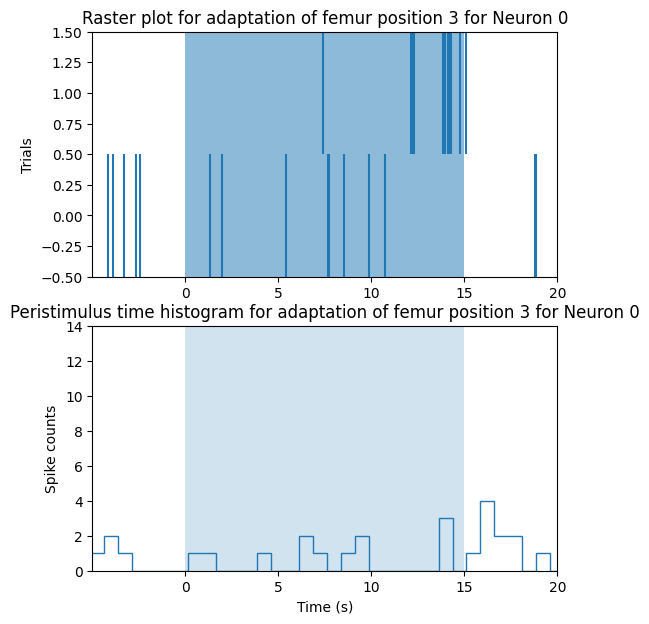

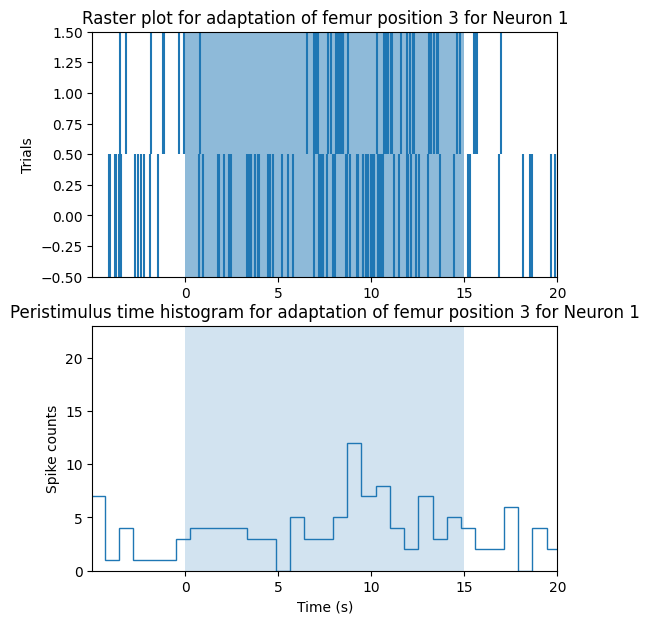

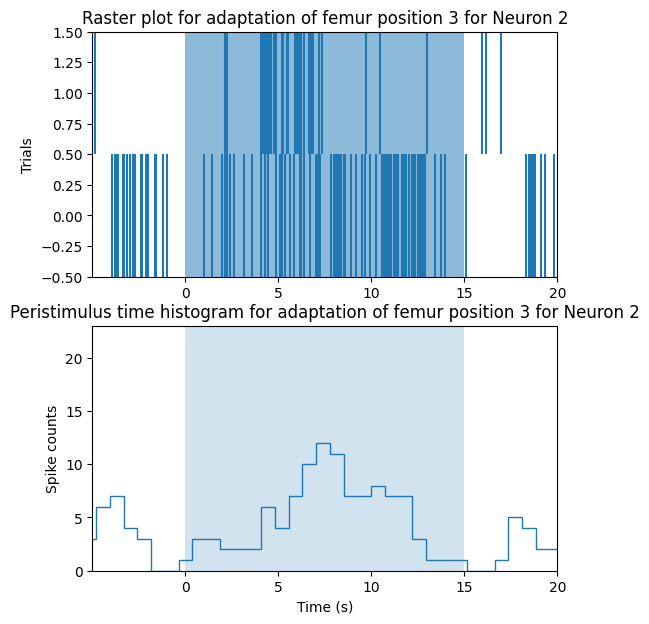

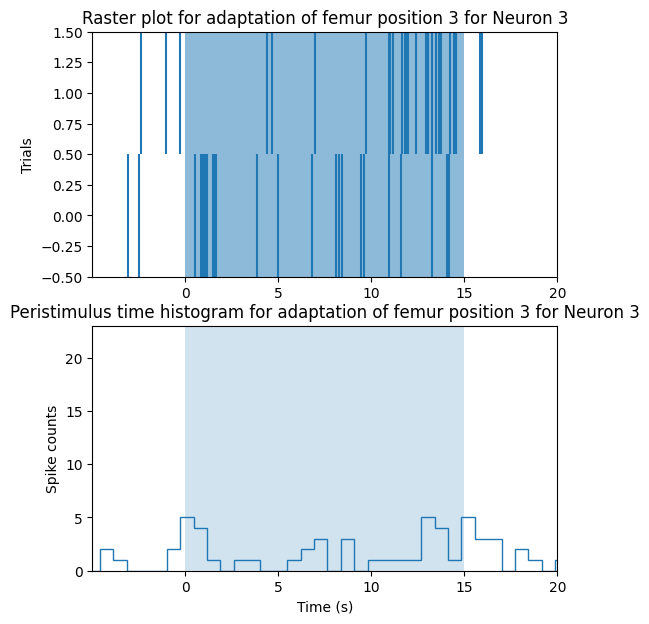

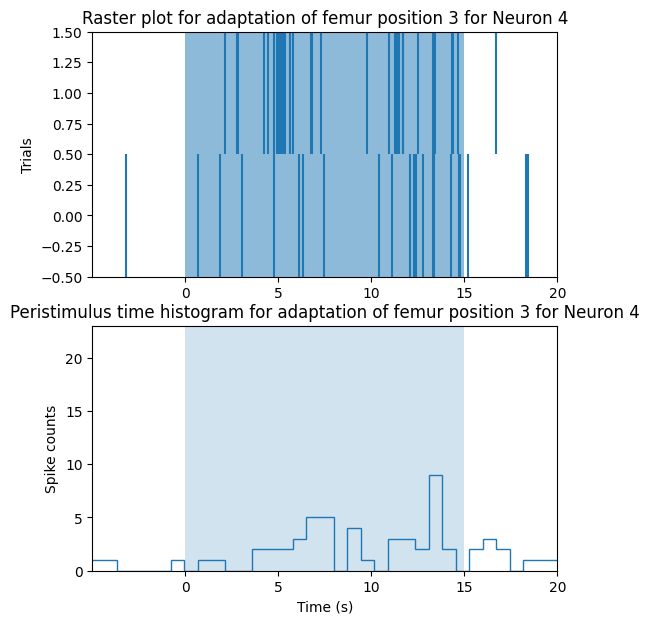

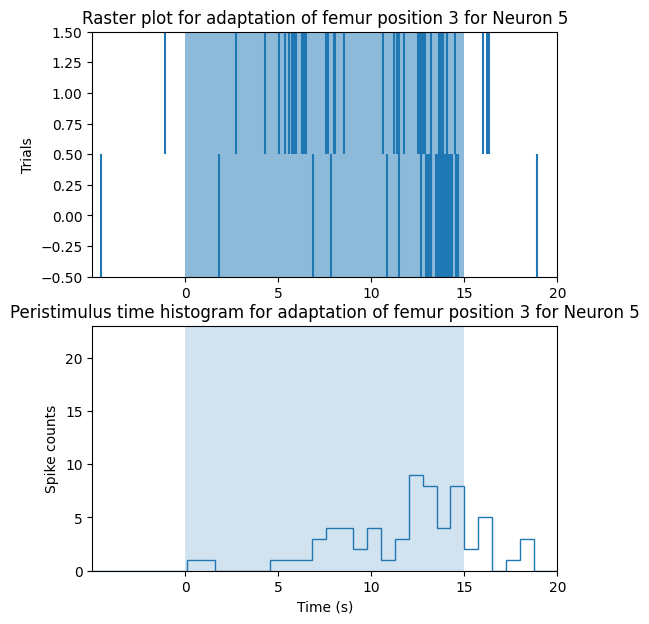

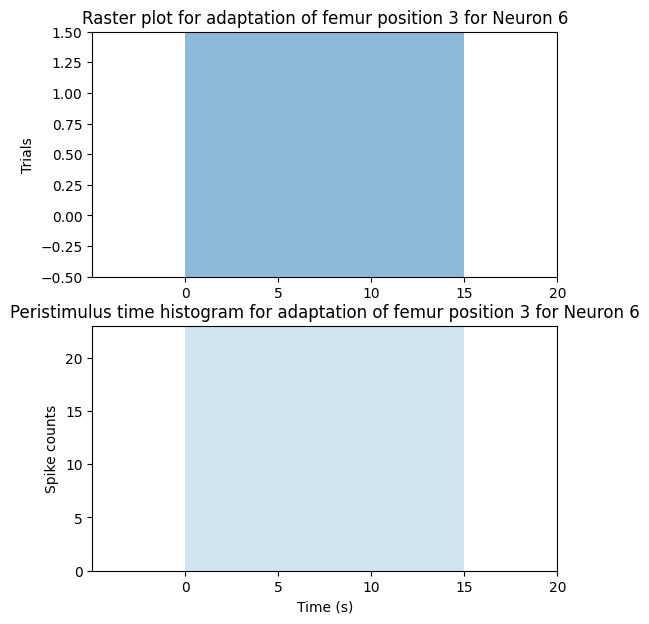

In [177]:
for CLUSTER in [0,1,2,3,4,5,6]:
    fig, axs = plt.subplots(2, figsize=(6, 7))
    axs[0].eventplot(
        [[x[0] - t_s * 10000 for i, x in enumerate(aligned_spikes) if spike_clusters[i] == CLUSTER] for t_s in [7, 35]])
    axs[0].set_xlim([-50000, 20 * 10000])
    ts = [0, 5, 10, 15, 20]
    axs[0].set_xticks([t * 10000 for t in ts], ts)
    # axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Trials')
    x = [0, 150000]
    y1 = [-.5, -0.5]
    axs[0].fill_between(x, y1, 1.5, alpha=0.5); axs[1].fill_between(x, y1, 23 if CLUSTER else 14, alpha=0.2)
    axs[0].set_ylim([-0.5, 1.5])
    axs[0].set_title(f'Raster plot for adaptation of femur position 3 for Neuron {CLUSTER}')

    times = [x[0] - t_s * 10000 for i, x in enumerate(aligned_spikes) if spike_clusters[i] == CLUSTER for t_s in [8, 33]]
    axs[1].hist(times, bins=100, histtype='step')
    axs[1].set_ylabel('Spike counts')
    axs[1].set_title(f'Peristimulus time histogram for adaptation of femur position 3 for Neuron {CLUSTER}')
    axs[1].set_xticks([t * 10000 for t in ts], ts)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_xlim([-50000, 20 * 10000])
    axs[1].set_ylim([0, 23 if CLUSTER else 14])
    plt.show()

In [169]:
data, info = loadescope(filenames['5847'])

KeyError: '5847'

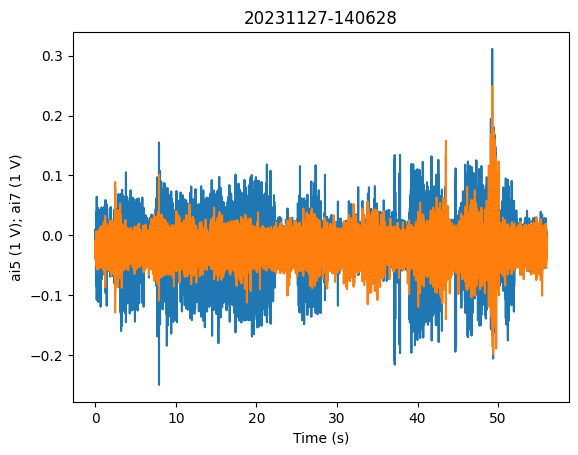

In [170]:
plotescope(data, info)

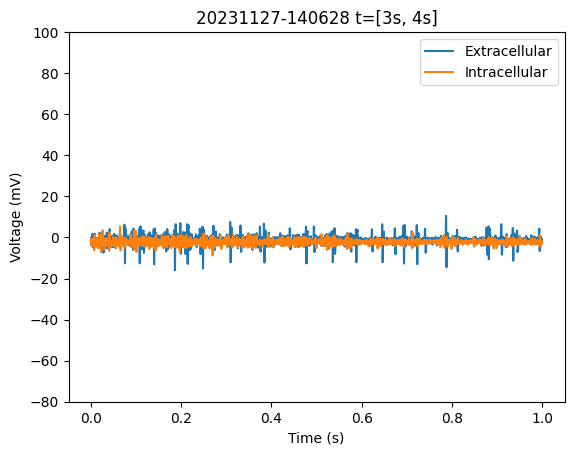

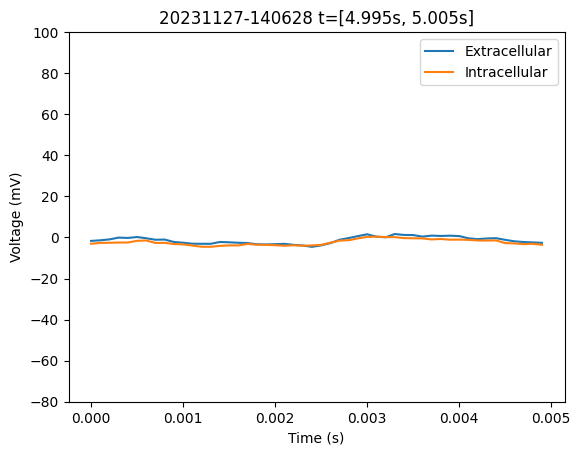

In [171]:
plot_region(data, info, 3, 4)

plot_spike(data, info, 5, window_size=100, thresh=4)

## Archive: SpikeInterface

I would like to use https://spikeinterface.readthedocs.io/en/0.98.2/how_to/get_started.html for two new features:
1. Spike onset detection
2. Spike clustering

In [172]:
ss.installed_sorters()

NameError: name 'ss' is not defined

In [ ]:
params = ss.get_default_sorter_params('spykingcircus2')
print("Parameters:\n", params)

desc = ss.get_sorter_params_description('spykingcircus')
print("Descriptions:\n", desc)

Parameters:
 {'general': {'ms_before': 2.5, 'ms_after': 3.5, 'local_radius_um': 100}, 'waveforms': {'max_spikes_per_unit': 200, 'overwrite': True}, 'filtering': {'freq_min': 300, 'dtype': 'float32'}, 'detection': {'peak_sign': 'neg', 'detect_threshold': 5}, 'selection': {'n_peaks_per_channel': 5000, 'min_n_peaks': 20000}, 'localization': {}, 'clustering': {}, 'matching': {}, 'registration': {}, 'common_reference': True, 'job_kwargs': {'n_jobs': -1, 'chunk_duration': '1s', 'verbose': False}}
Descriptions:
 {'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording', 'adjacency_radius': 'Radius in um to build channel neighborhood', 'detect_threshold': 'Threshold for spike detection', 'template_width_ms': 'Template width in ms. Recommended values: 3 for in vivo - 5 for in vitro', 'filter': 'Enable or disable filter', 'merge_spikes': 'Enable or disable automatic mergind', 'auto_merge': 'Automatic merging threshold', 'num_workers': 'Num

In [ ]:
params['selection']['min_n_peaks'] = 20

In [ ]:
recording = si.BinaryRecordingExtractor(
    ['data/160516.dat'], info['rate_hz'], 2, dtype=float, gain_to_uV=100, offset_to_uV=0)
recording.set_dummy_probe_from_locations(np.zeros([2,2]))

# subrec = recording.channel_slice(channel_ids=[1]) # .frame_slice(start_frame=0, end_frame=5 * info['rate_hz'])
sorting = ss.run_sorter('spykingcircus2', recording, sorter_param=params)# , docker_image=True)

AttributeError: Bad parameters: ['sorter_param']

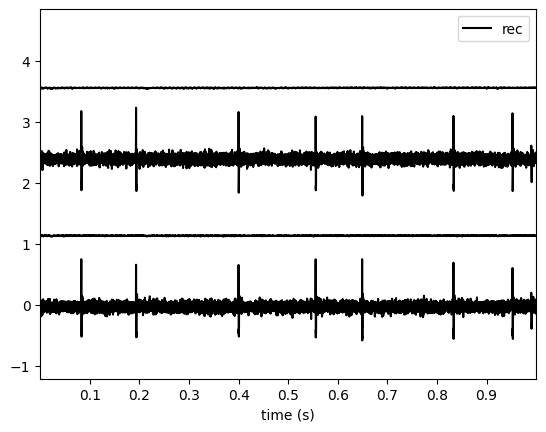

In [ ]:
sw.plot_timeseries(recording)
# sw.plot_rasters(sorting, time_range=(0, 5))

In [ ]:
rec2._recording_segments[0].

1196000

In [ ]:
def escope_to_SI(filename):
    data, info = loadescope(filename)
    

In [ ]:
t_spike=6.73 # 104.82
window_size=1000
thresh=20
savedir=None

t_window = t_spike - 0.005
tw_s = int((t_window % 1) * 10000)
data_trunc = data[:,int(np.floor(t_window)):int(np.floor(t_window))+1,tw_s:tw_s + window_size] * 100
# if np.max(data_trunc) < thresh and np.min(data_trunc) > -thresh: return

C, N, S = data_trunc.shape
tt = np.arange(N*S) / info['rate_hz']
trace = data_trunc[1].reshape(N*S).T

In [ ]:
sw.plot_timeseries({'ch0': trace}, time_range=(0, 5))

AttributeError: 'numpy.ndarray' object has no attribute 'get_num_segments'

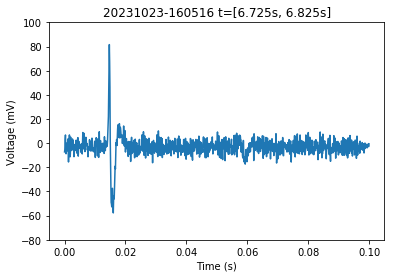

In [ ]:
plt.plot(tt, trace)
# plt.plot(tt, data_trunc[0].reshape(N*S).T)
plt.ylim(-80, 100)
plt.xlabel('Time (s)')
# plt.legend(['Extracellular', 'Intracellular'])
plt.ylabel("Voltage (mV)")
plt.title(f"{info['rundate']} t=[{round(t_window, 3)}s, {round(t_window + window_size/10000, 3)}s]")
if savedir: plt.savefig(f'{savedir}/t_{round(t_window, 3)}s_{round(t_window + window_size/10000, 3)}s.png')
plt.show()

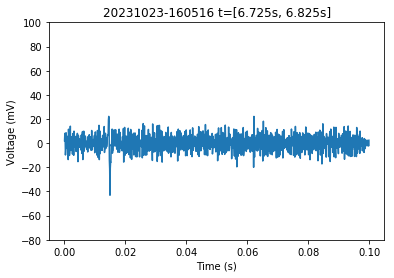

In [ ]:
plt.plot(tt[1:], trace[1:] - trace[:-1])
# plt.plot(tt, data_trunc[0].reshape(N*S).T)
plt.ylim(-80, 100)
plt.xlabel('Time (s)')
# plt.legend(['Extracellular', 'Intracellular'])
plt.ylabel("Voltage (mV)")
plt.title(f"{info['rundate']} t=[{round(t_window, 3)}s, {round(t_window + window_size/10000, 3)}s]")
if savedir: plt.savefig(f'{savedir}/t_{round(t_window, 3)}s_{round(t_window + window_size/10000, 3)}s.png')
plt.show()

In [ ]:
len(trace[1:]), len(trace[:-1])

(999, 999)